# Ejerccio de Tarea 01
Para los datos de la [Liga Nacional de Fútbol](https://github.com/HaydeePeruyero/MultivariateStatisticalAnalysis/blob/main/data/Liga_nacional_de_futbol.csv)

**a**. Ajustar un modelo de regresión lineal múltiple que relacione la cantidad de juegos ganados con las yardas por aire del equipo ($x_2$), el porcentaje de jugadas por tierra ($x_7$) y las yardas por tierra del contrario ($x_8$).  

**b**. Formar la tabla de análisis de varianza y probar la significancia de la regresión.  

**c**. Calcular el estadístico *t* para probar las hipótesis $H_0 : \beta_2 = 0$, $H_0 : \beta_7 = 0$ y $H_0 : \beta_8 = 0$. ¿Qué conclusiones se pueden sacar acerca del papel de las variables $x_2$, $x_7$ y $x_8$ en el modelo?  

**d**. Calcular $R^2$ y $R^2_{adj}$ para este modelo.  

**e**. Trazar una gráfica de probabilidad normal de los residuales. ¿Parece haber algún problema con la hipótesis de normalidad?  

**f**. Trazar e interpretar una gráfica de los residuales en función de la respuesta predicha.  

**g**. Trazar las gráficas de los residuales en función de cada una de las variables regresoras. ¿Implican esas gráficas que se especificó en forma correcta el regresor?  

**h**. Calcular un intervalo de confianza de $95\%$ para $\beta_7$ y un intervalo de confianza de $95\%$ para la cantidad media de juegos ganados por un equipo cuando $x_2 = 2300$, $x_7 = 56$ y $x_8 = 2100$.  

**i**. Ajustar un modelo a esos datos, usando solo $x_7$ y $x_8$ como regresores y probar la significancia de la regresión.  

**j**. Calcular $R^2$ y $R^2_{adj}$. Compararlos con los resultados del modelo anterior.  

**k**. Calcular un intervalo de confianza de $95\%$ para $\beta_7$. También, un intervalo de confianza de $95\%$ para la cantidad media de juegos ganados por un equipo cuando $x_7 = 56$ y $x_8 = 2100$. Comparar las longitudes de esos intervalos de confianza con las longitudes de los correspondientes al modelo anterior.  

**l**. ¿Qué conclusiones se pueden sacar de este problema, acerca de las consecuencias de omitir un regresor importante de un modelo?

## 0. Importar

### 0.1. Importar Librerías

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats

### 0.2. Cargar Datos

In [ ]:
DatasetFutbol = pd.read_csv(
    './Liga_nacional_de_futbol.csv',
)

TargetLabel , *FeatureLabels = DatasetFutbol.columns

DatasetFutbol.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,10,2113,1985,38.9,64.7,4,868,59.7,2205,1917
1,11,2003,2855,38.8,61.3,3,615,55.0,2096,1575
2,11,2957,1737,40.1,60.0,14,914,65.6,1847,2175
3,13,2285,2905,41.6,45.3,-4,957,61.4,1903,2476
4,10,2971,1666,39.2,53.8,15,836,66.1,1457,1866


## **a**. Modelo de Regresión

In [ ]:
FeaturesModel = ['x2','x7','x8']
LinearModel = smf.ols(
    f"{TargetLabel} ~ " + ' + '.join(FeaturesModel),
    data = DatasetFutbol,
).fit()

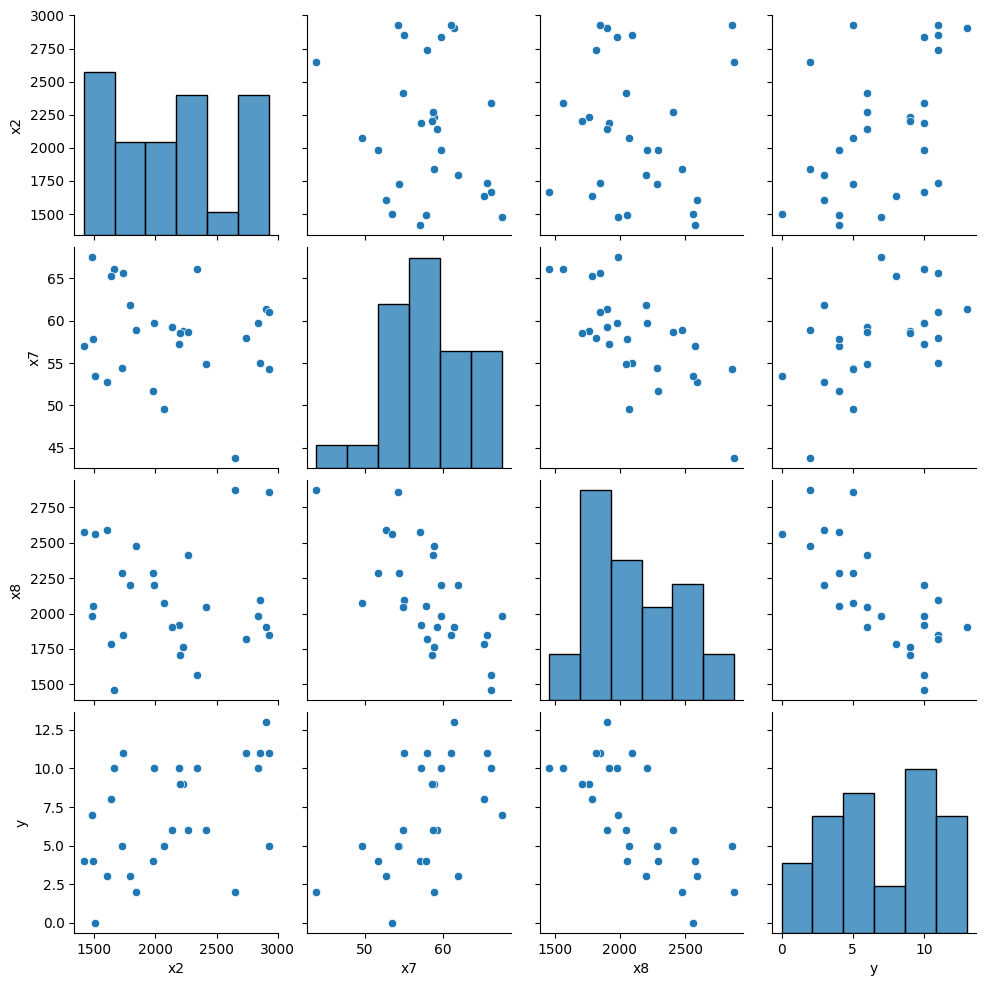

In [37]:
sns.pairplot(
    DatasetFutbol[[*FeaturesModel,TargetLabel]]
)

## **b**. Tabla de Análisis de Varianza

In [29]:
def ANOVATable(
        LinearModel,
    ) -> pd.DataFrame:
    
    ColumnsANOVA = [
        'Fuente Variación',
        'Suma de Cuadrados',
        'Grados de Libertad',
        'Cuadrados Medios',
        'F_0',
    ]
    Table = pd.DataFrame(columns=ColumnsANOVA)
    Table['Fuente Variación'] = ['Regresión','Residuales','Total']

    MeanSquares_Reg = LinearModel.mse_model
    MeanSquares_Res = LinearModel.mse_resid
    MeanSquares_Tot = LinearModel.mse_total
    Table['Cuadrados Medios'] = [MeanSquares_Reg,MeanSquares_Res,MeanSquares_Tot]

    DegreeFreedom_Reg = LinearModel.df_model
    DegreeFreedom_Res = LinearModel.df_resid
    DegreeFreedom_Tot = DegreeFreedom_Reg + DegreeFreedom_Res
    Table['Grados de Libertad'] = [DegreeFreedom_Reg,DegreeFreedom_Res,DegreeFreedom_Tot]

    Table['Suma de Cuadrados'] = Table['Cuadrados Medios']*Table['Grados de Libertad']

    Table['F_0'] = [LinearModel.fvalue,np.nan,np.nan]

    return Table.set_index('Fuente Variación')

In [ ]:
ANOVATable(
    LinearModel,
)

,Suma de Cuadrados,Grados de Libertad,Cuadrados Medios,F_0
Fuente Variación,,,,
Regresión,257.094282,3.0,85.698094,29.43687
Residuales,69.870004,24.0,2.911250,NaN
Total,326.964286,27.0,12.109788,NaN


## **c**. Prueba sobre los Coeficientes Individuales de Regresión

In [31]:
LevelSignificance = 0.05

In [49]:
def TestIndividualCoefficients(
        LinearModel,
        Dataset: pd.DataFrame,
        FeaturesModel: list[str],
        LevelSignificance: float = 0.05,
    ):

    CovarianceEstimateBetas = CalculatedCovarianceEstimateBetas(LinearModel,Dataset,FeaturesModel)

    t_Value_1 = stats.t.ppf(1-LevelSignificance/2,LinearModel.df_resid)
    print(f't_1 :: {t_Value_1}')
    print(f'\nt_0 Values')
    for index_feature , (feature,beta_value) in enumerate(LinearModel.params[1:].items(),1):
        tValue_0 = beta_value / np.sqrt(CovarianceEstimateBetas[index_feature,index_feature])
        print(f'{feature} :: {tValue_0}')


def CalculatedCovarianceEstimateBetas(
        LinearModel,
        Dataset: pd.DataFrame,
        FeaturesModel: list[str],
    ) -> np.ndarray:

    SizeN = Dataset.shape[0]
    DataMatrix = np.concat(
        [
            np.ones((SizeN,1)),
            Dataset[FeaturesModel].to_numpy()
        ],
        axis=1,
    )

    EstimateSquareSigma = LinearModel.mse_resid
    return EstimateSquareSigma*np.linalg.inv(DataMatrix.T@DataMatrix)

In [ ]:
TestIndividualCoefficients(
    LinearModel,
    DatasetFutbol,
    FeaturesModel,
)

t_1 :: 2.0638985616280205

t_0 Values
x2 :: 5.177090239985967
x7 :: 2.198261682781837
x8 :: -3.7710364517268267


## **d**. Métricas del Modelo

In [52]:
print(f'R^2 :: {LinearModel.rsquared}')
print(f'R^2 Adjustada:: {LinearModel.rsquared_adj}')

R^2 :: 0.7863069233109538
R^2 Adjustada:: 0.759595288724823


## **e**. Gráfica de Probabilidad Normal de los Residuales

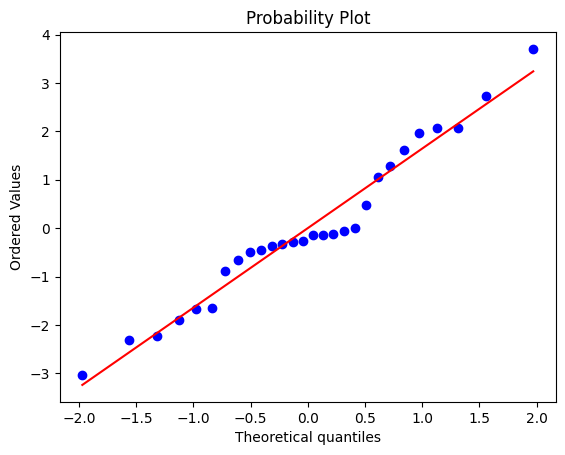

In [67]:
fig , axes = plt.subplots()
_ = stats.probplot(
    LinearModel.resid,
    dist = 'norm',
    plot = axes,
)

## **f**. Gráfica de los Residuales en Función de la Respuesta Predicha

<Axes: xlabel='y', ylabel='None'>

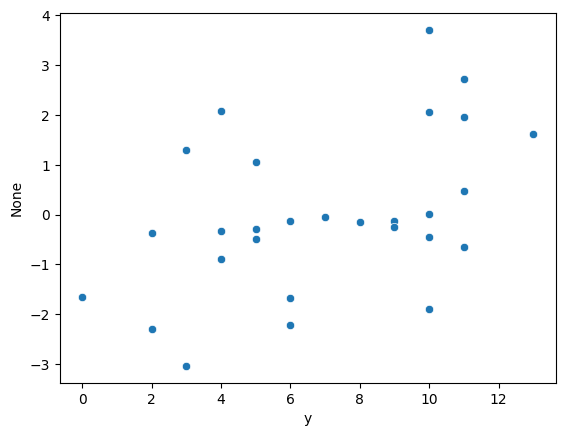

In [68]:
sns.scatterplot(
    x = DatasetFutbol[TargetLabel],
    y = LinearModel.resid,
)

## **g**. Gráficas de los Residuales en Función de las Variables Regresoras

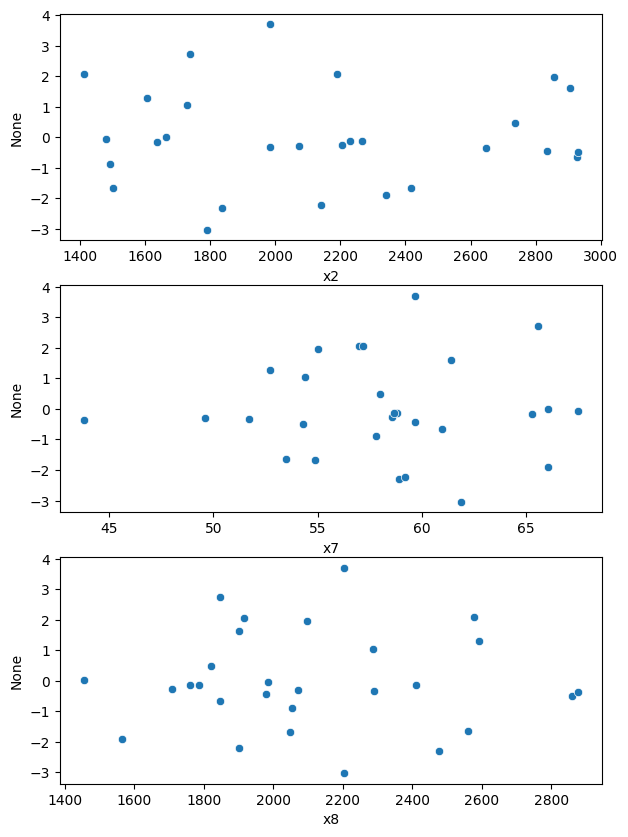

In [74]:
fig , axes = plt.subplots(
    3,
    figsize = (7,10)
)

for feature , ax in zip(FeaturesModel,axes.ravel()):
    sns.scatterplot(
        x = DatasetFutbol[feature],
        y = LinearModel.resid,
        ax = ax,
    )